In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from msdm.domains.gridgame.tabulargridgame import TabularGridGame
from msdm.domains.gridworld.mdp import GridWorld
from msdm.algorithms.multiagentqlearning import MultiAgentQLearning
from msdm.algorithms.friendfoeq import FriendFoeQ
from msdm.core.problemclasses.stochasticgame.policy.tabularpolicy import SingleAgentPolicy
from msdm.core.assignment.assignmentmap import AssignmentMap
import msdm
import numpy as np
import importlib
import itertools


In [3]:
new_gamestring = """
# # # # # # # 
# A1 . A2 . A0 #
# . . . . . # 
# G1 . G2 . G0 #
# # # # # # #  
""".strip()

test_gamestring = """
# # # # # # # 
# A1 . A2 . A0 #
# G1 . G2 . G0 #
# # # # # # #  
""".strip()
gg = TabularGridGame(new_gamestring,agent_symbols=("A0","A1","A2"),goal_symbols=(
                     ("G0", ("A0", )),
                     ("G1", ("A1", )),
                     ("G2",("A2", )),
                     ("G", ("A0", "A1"))),)
# gg = TabularGridGame(new_gamestring,agent_symbols=("A0","A1","A2"))
gg.state_list
print("State list generated")

State list generated


In [4]:
# learning agents 
learning_agents = ["A1","A2","A0"]
# Set up policies and friend-foe relations
friends = {"A1":["A2"],"A2":["A0"],"A0":["A1"]}
foes = {"A1":["A0"],"A0":["A2"],"A2":["A1"]}
a0_policy = AssignmentMap()
indiv_actions = gg.joint_actions(gg.initial_state_dist().sample())["A0"]

for i,s in enumerate(gg.state_list):
    actions = list(gg.joint_actions(s)["A0"])
    random_action = np.random.choice(len(actions))
    a0_policy[s] = AssignmentMap()
    for action in actions:
        if action == actions[random_action]:
            a0_policy[s][action] = 1.0
        else:
            a0_policy[s][action] = 0.0
a0_policy = SingleAgentPolicy("A0",gg.state_list,indiv_actions,gg.joint_action_list,policy_dict=a0_policy)
# other_policies = {"A0":a0_policy}
other_policies = {}

In [5]:
# learner = FriendFoeQ(learning_agents,friends,foes,other_policies,num_episodes=100,epsilon=.1,discount_rate=.99)
learner = MultiAgentQLearning(learning_agents,other_policies,num_episodes=10000,epsilon=.3,discount_rate=.99)

In [6]:
# res = learner.train_on(gg)

In [7]:
# result = res.pi.run_on(gg,maxSteps=100)

Plotting State Values: 100%|██████████| 15/15 [00:00<00:00, 895.70it/s]


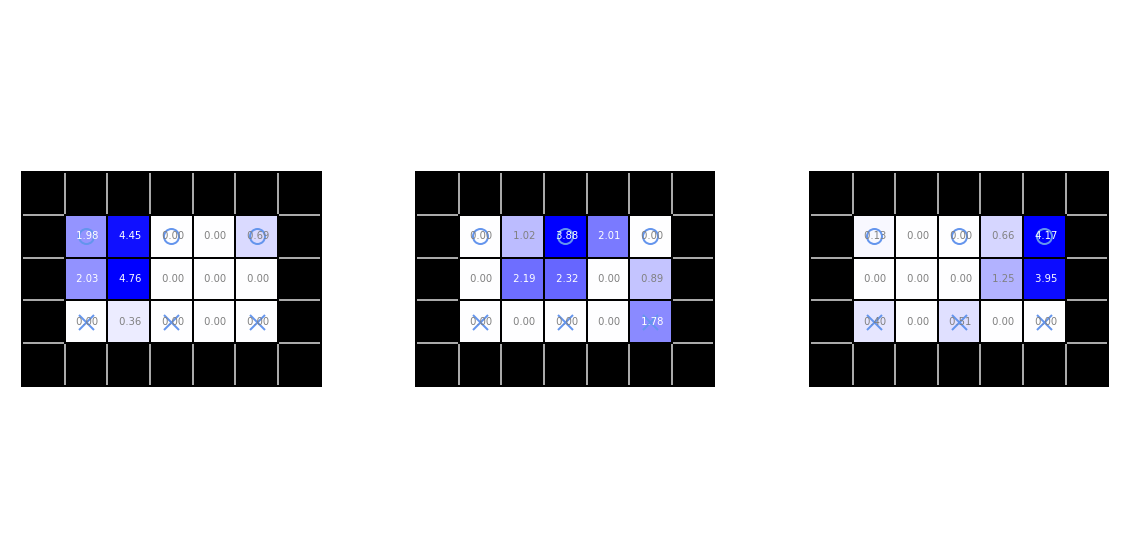

Plotting State Values: 100%|██████████| 15/15 [00:00<00:00, 802.89it/s]


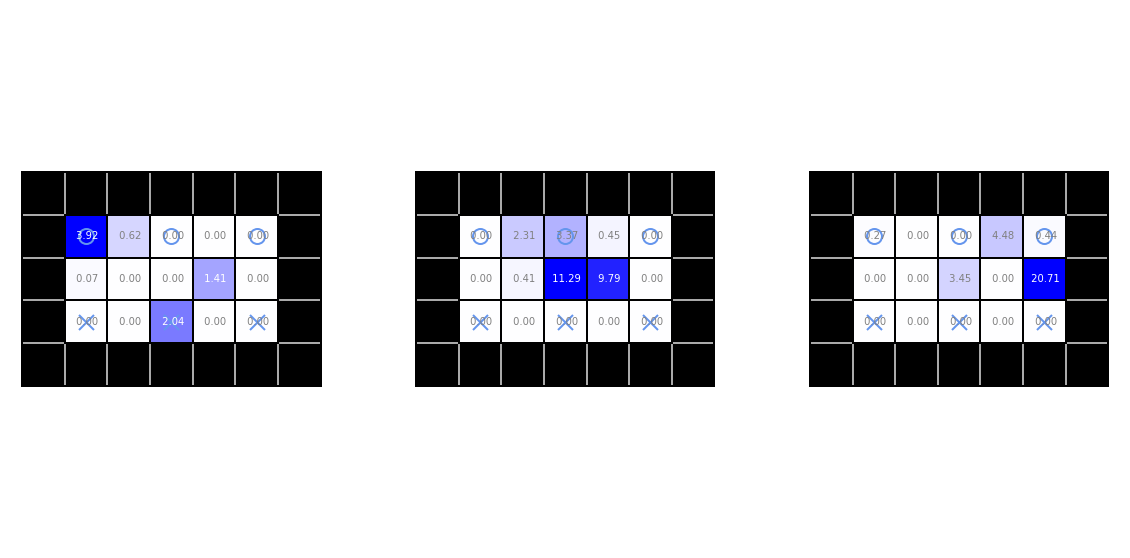

Calculating Projected Q-Values:  80%|████████  | 12/15 [02:09<00:30, 10.25s/it]

In [ ]:
for k in range(5):
    learner = MultiAgentQLearning(learning_agents,other_policies,num_episodes=5000,epsilon=.1,discount_rate=.99)
    res = learner.train_on(gg)
    result = res.pi.run_on(gg,maxSteps=100)
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    for i,agent_name in enumerate(learning_agents):
        plotter = gg.plot(ax=axes[i])
        q_matrix = res.pi.single_agent_policies[agent_name].q_matrix
        occupancy_matrix = res.pi.occupancy_matrix
        plotter.plot_state_map(res.pi.positionMapping(agent_name,q_matrix,occupancy_matrix))
    plt.show()